In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
import functools
import collections
import random

#generate random id
import uuid

#ICC in python
import pingouin as pg

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score
from xgboost import plot_importance
#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool
#to use all except one core
import multiprocessing

#normality test of transitions
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from termcolor import colored

#plot
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\camil\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import is_WG_open, ConfMat, list_of_zones, res_intodico, ShapiroTest, AgostinosK2Test
import config_origins as config

C:\Users\camil\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
random.seed(0)

# Download Input Data

In [4]:
#define parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
dico_garden_opening_hour = config.dico_garden_opening_hour
dico_BatchID_endhour = config.dico_BatchID_endhour
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')    
path_extracted_data_cleaning_model = os.path.join(path_extracted_data_cleaning,'model')    
#feature for model
li_cont_select = config.li_cont_select
li_bin = config.li_bin
li_cat_select = config.li_cat_select
path__ = os.path.join(path_extracted_data_cleaning,'1secTS')
#create a director if not existing
if not os.path.exists(path__):
    os.makedirs(path__)

In [5]:
df = pd.read_csv(os.path.join(path_extracted_data_cleaning, id_run+'InputCleaning.csv'), parse_dates=['Timestamp', 'date'], 
                 dayfirst=True, sep=';')
df = shuffle(df)
df['VideoAnalyse'] = df['VideoAnalyse'].map(lambda x: int(x))
df_init = df.copy()
print(df.shape)
df.head(3)

(5356, 34)


,Timestamp,TagID,HenID,Zone,PenID,VideoAnalyse,system,date,type,signalstrength,...,duration,previous_duration,algo_type,previousZone==NextZone,next_duration,next2zone==Zone,previous2zone==Zone,zone3_match_exist,BatchID,ObservedZone
4484,2020-10-18 12:47:36,92,hen_113,2_Zone,pen9,1,8 - 9,2020-10-18,students,14.0,...,80.0,235.0,cleaning,False,35.0,0.0,1.0,0.0,NaN,2_Zone
4793,2020-10-19 16:19:55,89,hen_45,3_Zone,pen12,1,10 - 12,2020-10-19,students,10.0,...,73.0,24.0,cleaning,True,375.0,0.0,0.0,1.0,NaN,3_Zone
4619,2020-10-18 11:25:12,91,hen_164,4_Zone,pen9,1,8 - 9,2020-10-18,students,22.0,...,89.0,124.0,cleaning,True,12.0,1.0,1.0,1.0,NaN,4_Zone


# Data preprocessing

In [6]:
#scaling numerical data: necessary due to duration high values
display(df[li_cont_select].head(3))
sc = StandardScaler()
li_scale = [x for x in li_cont_select if x not in li_bin]
df[li_scale] = sc.fit_transform(df[li_scale])
display(df[li_cont_select].head(3))

#display categoricalfeatures
df[li_cat_select].head(3)

,signalstrength,signalstzone2,duration,next_duration,previous_duration,next2zone==Zone,previous2zone==Zone,zone3_match_exist
4484,14.0,8.0,80.0,35.0,235.0,0.0,1.0,0.0
4793,10.0,6.0,73.0,375.0,24.0,0.0,0.0,1.0
4619,22.0,9.0,89.0,12.0,124.0,1.0,1.0,1.0


,signalstrength,signalstzone2,duration,next_duration,previous_duration,next2zone==Zone,previous2zone==Zone,zone3_match_exist
4484,0.688701,0.13590,-0.046458,-0.055927,-0.022843,0.0,1.0,0.0
4793,-0.273020,-0.38420,-0.047369,-0.012083,-0.037162,0.0,0.0,1.0
4619,2.612143,0.39595,-0.045288,-0.058893,-0.030376,1.0,1.0,1.0


,Zone,zone2_match,previous1_zone,next1_zone,PenID
4484,2_Zone,1_Zone,1_Zone,3_Zone,pen9
4793,3_Zone,3_Zone,3_Zone,3_Zone,pen12
4619,4_Zone,5_Zone,5_Zone,5_Zone,pen9


# Split into training-validation and testing (holdout dataset)

In [7]:
df_testing = df[df['algo_type']=='verification'].copy()
df_testing['VideoAnalyse'].value_counts()

1    821
0     42
Name: VideoAnalyse, dtype: int64

In [8]:
model = CatBoostClassifier()
model.load_model(os.path.join(path_extracted_data_cleaning_model,'FINAL_Catboost'));

# Relevance on TESTING DATA

In [9]:
##########################################################################################################
################################################ predict #################################################
##########################################################################################################
predictions = model.predict(df_testing.filter(li_cont_select+li_cat_select, axis=1))
prediction_proba = model.predict_proba(df_testing.filter(li_cont_select+li_cat_select, axis=1))
df_testing['model_prediction'] = predictions
df_testing['model_prediction_proba0'] = [round(x[0],2) for x in prediction_proba]
df_testing['model_prediction_proba1'] = [round(x[1],2) for x in prediction_proba]
#df_testing.groupby(['Zone','model_prediction'])['date'].count().reset_index()
#add the zone that would be selected with this algorithm output: if==0, then the true zone is the one before
#df_testing['model_prediction_init'] = df_testing['model_prediction'].astype(str)
df_testing['VideoAnalyse'] = df_testing['VideoAnalyse'].astype(int)
df_testing['model_ObservedZone'] = df_testing.apply(lambda x: x['Zone'] if x['model_prediction']==1 else x['previous1_zone'],
                                                    axis=1)
df_testing['tracking_prediction'] = 1
#save
df_testing.to_csv(os.path.join(path_extracted_data_cleaning, id_run+'_TestingMethods.csv'), index=False, sep=';')
display(df_testing.head(3))

,Timestamp,TagID,HenID,Zone,PenID,VideoAnalyse,system,date,type,signalstrength,...,next2zone==Zone,previous2zone==Zone,zone3_match_exist,BatchID,ObservedZone,model_prediction,model_prediction_proba0,model_prediction_proba1,model_ObservedZone,tracking_prediction
3636,2020-10-21 13:02:08,106,hen_29,3_Zone,pen9,1,8 - 9,2020-10-21,students,-0.27302,...,1.0,0.0,1.0,ID21,3_Zone,1,0.0,1.0,3_Zone,1
3387,2020-10-14 14:26:00,184,hen_110,3_Zone,pen9,1,8 - 9,2020-10-14,students,-0.03259,...,0.0,0.0,1.0,ID10,3_Zone,1,0.0,1.0,3_Zone,1
3869,2020-10-23 15:16:59,137,hen_140,3_Zone,pen10,1,10 - 12,2020-10-23,students,-0.03259,...,1.0,0.0,1.0,ID33,3_Zone,1,0.0,1.0,3_Zone,1


In [ ]:
#small verification of algorithm for batch=ID30
df_test = df_testing[df_testing['Timestamp']=='23.10.2020  15:15:40']
#look on initial datasets
display(df_init[df_init['Timestamp']=='23.10.2020  15:15:40'][['Timestamp','HenID',
                                                               'VideoAnalyse']+li_cont_select+li_cat_select])
model.predict_proba(df_test.filter(li_cont_select+li_cat_select, axis=1).values)

#visualise how correct is the prediction compared to the certainty of the algo
df_testing['is_correct4plot'] = df_testing.apply(lambda x: x['VideoAnalyse']==x['model_prediction'], axis=1)
display(df_testing[['VideoAnalyse', 'model_prediction_init', 'model_prediction_proba0', 
                    'model_prediction_proba1','is_correct4plot']].head(3))
df_testing.groupby(['is_correct4plot','VideoAnalyse'])[['model_prediction', 'model_prediction_proba0', 
                                                    'model_prediction_proba1']].agg(lambda x: np.median(list(x))).reset_index()

#add rule: if max proba is <0.8 then keep correct record. Can be used to comapre the method!!
df_testing['model_prediction'] = df_testing.apply(lambda x: '1' if max(x['model_prediction_proba0'],
                                                            x['model_prediction_proba1'])<0.8 else x['model_prediction_init'], axis=1)
df_testing['is_correct4plot_'] = df_testing.apply(lambda x: x['VideoAnalyse']==x['model_prediction'], axis=1)
display(df_testing['is_correct4plot'].value_counts(), df_testing['is_correct4plot_'].value_counts())

In [10]:
##########################################################################################################
################################# select pairs' combinations of batches ##################################
##########################################################################################################

#number of combination's pair to run for each size
nbr_comb = 10
#minimum nbr of batches to have in a run
min_nbr_batch = 7 #5 is the minimum for transition reliability, so lets have it to be "6"
#compute all possible batch combinations of any size
li_batch = df_testing['BatchID'].unique()

#list of distinct pairs of batch combinations of different size
li_selected_combination_pairs = []
#to have distinct pairs, we cant do more than half of what we have
for nbr_batch in tqdm.tqdm(range(min_nbr_batch, int(len(li_batch)/2))):
    li_sel = []
    while len(li_sel)!=nbr_comb:
        li_pair1 = random.sample(list(li_batch), nbr_batch)
        li_pair2 = random.sample([x for x in li_batch if x not in li_pair1], nbr_batch) 
        li_sel.append([li_pair1,li_pair2])
    li_selected_combination_pairs.extend(li_sel)
#do the one with all batches for final outputs
li_selected_combination_pairs.append([tuple(li_batch),tuple(li_batch)])
print(li_selected_combination_pairs[-3])
print(li_selected_combination_pairs[-2])

100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 2339.36it/s]

[['ID11', 'ID22', 'ID6', 'ID40', 'ID32', 'ID24', 'ID28', 'ID7', 'ID12', 'ID23', 'ID42', 'ID36', 'ID18', 'ID29', 'ID16', 'ID9', 'ID5', 'ID26', 'ID34', 'ID17'], ['ID25', 'ID15', 'ID27', 'ID30', 'ID33', 'ID31', 'ID10', 'ID13', 'ID35', 'ID38', 'ID19', 'ID14', 'ID20', 'ID3', 'ID39', 'ID8', 'ID2', 'ID41', 'ID37', 'ID4']]
[['ID35', 'ID3', 'ID12', 'ID30', 'ID4', 'ID9', 'ID39', 'ID36', 'ID8', 'ID17', 'ID10', 'ID21', 'ID42', 'ID11', 'ID38', 'ID5', 'ID37', 'ID18', 'ID24', 'ID25'], ['ID14', 'ID32', 'ID20', 'ID1', 'ID13', 'ID22', 'ID16', 'ID28', 'ID7', 'ID40', 'ID33', 'ID19', 'ID23', 'ID26', 'ID6', 'ID31', 'ID15', 'ID27', 'ID29', 'ID2']]


In [11]:
###############################################################################################################################
###############################################################################################################################
############################################# RUN OVER SEVERAL BATCH COMBINATIONS #############################################
###############################################################################################################################
###############################################################################################################################

#start recording the time it last
START_TIME = time.clock()
li_df  = []
is_done = False
for li_batch1, li_batch2 in tqdm.tqdm(li_selected_combination_pairs):
    
    #select a unique runID per pair of batch combination
    runID = uuid.uuid1()
    nbr_b = len(li_batch1)
    
    for i,li_batch in enumerate([li_batch1, li_batch2]):
        #dont do the second batch if its the same as the first one, i.e. if its the final output, but print visuals
        if (li_batch1==li_batch2) & (is_done==True):
            #to sort the yaxis
            dico_zone_order = {'1_Zone':0, '2_Zone':1, '3_Zone':2, '4_Zone':3, '5_Zone':4}
            li_ts = ['Zone','model_ObservedZone','ObservedZone','binning_zone']
            #for each batch draw 4 timeseries
            for BatchID, df_plt in tqdm.tqdm(df_final.groupby(['BatchID'])):
                df_plt = df_plt.sort_values(['Timestamp']).copy()
                l = len(li_ts) ; c = 1
                fig = plt.figure(figsize=(c*5, l*1))
                for i,v in enumerate(li_ts):
                    df_plt[v] = df_plt[v].map(lambda x: int(dico_zone_order[x]))       
                    plt.subplot(l,c,i+1)
                    plt.plot(df_plt['Timestamp'].tolist(), df_plt[v].tolist())
                    plt.xticks(fontsize=4)
                    plt.yticks(fontsize=4)
                    plt.title(v+' '+BatchID, size=7)
                plt.savefig(os.path.join(path_extracted_data_cleaning, BatchID+'.png'), format='png', bbox_inches='tight', 
                            dpi=300)
                plt.clf()
                plt.close("all")                      
            
            #test normality of transitions (per zone, as for all zone is not working
            print('test normality of transitions per zones')
            for z,df__ in df_transition.groupby('variable'):
                print('--------------------', z)
                for c in ['Zone', 'model_ObservedZone', 'binning_zone','ObservedZone']:
                    #stat, p = ShapiroTest(list(df__[c].dropna()))
                    #print(stat, p)
                    stat, p = AgostinosK2Test(list(df__[c].dropna()))
                    print(stat, p)
                
            break
            
        df_testing_ = df_testing[df_testing['BatchID'].isin(li_batch)].copy()
        ##########################################################################################################
        ########################################### create duration TS ###########################################
        ##########################################################################################################
        li_df_dur = []
        li_col = ['Zone','VideoAnalyse','model_ObservedZone','ObservedZone','PenID','HenID','Timestamp','BatchID']
        for BatchID,df_ in df_testing_[li_col].groupby(['BatchID']):
            df_ = df_.sort_values('Timestamp',ascending=True)
            #select the list of timestamp we want (i.e. at one second level)
            mi = min(df_['Timestamp'].tolist())
            ma = max(df_['Timestamp'].tolist())
            #extend the daterange if the batch is in dico_BatchID_endhour
            if BatchID in dico_BatchID_endhour.keys():
                ma = dt.datetime(ma.year,ma.month,ma.day,dico_BatchID_endhour[BatchID],0,0)
            #print(mi, ma)
            Daterange = pd.date_range(start = mi+dt.timedelta(seconds=(60-mi.second)), 
                                      end = ma-dt.timedelta(seconds=(ma.second+1)), 
                                      freq = 'S') 
            #print(Daterange[0:2])
            #print(Daterange[-2:])

            ################### 1 sec ts: tracking method & model method & true observation
            ### extend to 1 seconds level
            #add missing seconds (i.e. all seconds that never had a record) and fillnan with last non-nan values by propagating last 
            # observation forward to next valHenIDmi = min(df_['Timestamp'].tolist())
            df_.set_index('Timestamp', inplace=True)
            df__ = df_.reindex(Daterange, method='ffill').reset_index()
            #display(df__.head(5))
            #display(df__.tail(5))
            df__.rename(columns={'index':'Timestamp'}, inplace=True)
            #display(df__.head(3))
            df__.to_csv(os.path.join(path__,'1secTimeSeries'+str(BatchID)+'.csv'), sep=';', index=False)

            ################### binning method at 60 sec period
            #First take only the wanted timestamps (1 per seconds)
            #due to the 60 sec period bining, we need to exclude some of the first and last seconds in order to take into account 
            #minutes for which we have the full information only
            DaterangeBIN = [Daterange[i] for i in range(len(Daterange)) if i%60==0]
            #add new timestamp to the initial file
            df_date = pd.DataFrame({'New_Timestamp':DaterangeBIN})
            df_date['New_Timestamp'] = df_date['New_Timestamp'].map(lambda x: pd.to_datetime(x))
            df_bin = pd.merge_asof(df__, df_date, left_on=['Timestamp'], right_on=['New_Timestamp'], direction='forward')

            #Then bin the data
            h = 'Zone'
            df_bin = df_bin[[h,'New_Timestamp']].copy()
            df_bin['nbr_sec'] = 1
            df_bin = df_bin.groupby(['New_Timestamp',h])['nbr_sec'].sum().reset_index() #sum to count as we have seconds
            df_bin = df_bin.groupby(['New_Timestamp'])[[h,'nbr_sec']].agg(lambda x: tuple(x)).reset_index()
            df_bin['most_frequent_zone'] = df_bin.apply(lambda x: x[h][x['nbr_sec'].index(max(x['nbr_sec']))], axis=1)
            df_bin['nbr_duration_per_zone'] = df_bin.apply(lambda x: str({x[h][k]:x['nbr_sec'][k] for k in range(len(x[h]))}), axis=1)
            df_bin['nbr_lost_duration_per_zone'] = df_bin['nbr_duration_per_zone'].map(lambda x: str({z:v for z,v in eval(x).items() if \
                                                                               v!=max(eval(x).values())}))
            df_bin['nbr_lost_duration'] = df_bin['nbr_lost_duration_per_zone'].map(lambda x: sum(eval(x).values()))
            df_bin['perc_lost_duration'] = df_bin['nbr_lost_duration'].map(lambda x: x/60*100)
            df_bin['day'] = df_bin['New_Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day))
            df_bin.to_csv(os.path.join(path__ ,'bining'+str(BatchID)+'.csv'), sep=';', index=False)
            #display(df_bin.head(3))    

            #extend to 1sec ts
            df_bin = df_bin[['most_frequent_zone','New_Timestamp']]
            df_bin.set_index('New_Timestamp', inplace=True)
            df_bin1sec = df_bin.reindex(Daterange, method='ffill').reset_index()
            df_bin1sec.rename(columns={'index':'Timestamp','most_frequent_zone':'binning_zone'}, inplace=True)
            df_bin1sec.to_csv(os.path.join(path__,'1secTimeSeries_bining'+str(BatchID)+'.csv'), sep=';', index=False)
            #display(df_bin1sec.head(3))

            #join with bining
            df_final = pd.merge(df__, df_bin1sec, on=['Timestamp'], how='outer')
            df_final.to_csv(os.path.join(path__,'1secTimeSeries_ALL_'+str(BatchID)+'.csv'), sep=';', index=False)
            li_df_dur.append(df_final)
        #concat all final 1sec into one big
        df_final = pd.concat(li_df_dur)
        df_final.to_csv(os.path.join(path_extracted_data_cleaning,'1secTimeSeries_reliability.csv'), sep=';', index=False)
        #display(df_final.head(3))

        ##########################################################################################################
        ########################################### create duration TS ###########################################
        ##########################################################################################################
        #in case: total nbr of zone, issue: not enough observatoin for kappa test 
        #df_transition = df_final.groupby(['BatchID'])[['Zone','model_ObservedZone','ObservedZone',
        #                                               'binning_zone']].agg(lambda x: len(list_of_zones(x))-1).reset_index()
                
        li_df_zone = []
        for c in ['Zone','model_ObservedZone','ObservedZone','binning_zone']:
            df_transition_ = df_final.groupby(['BatchID'])[c].agg(lambda x: dict(Counter(list_of_zones(x)[1:]))).reset_index()
            for z in df_final[c].unique():
                df_transition_[z] = df_transition_[c].map(lambda x: x.get(z,0))
            df_ = pd.melt(df_transition_, id_vars=['BatchID'], value_vars=df_final[c].unique())
            df_.rename(columns={'value':c}, inplace=True)
            li_df_zone.append(df_)
        df_transition = li_df_zone[0]
        for df_ in li_df_zone[1:]:
            df_transition = pd.merge(df_, df_transition, on=['BatchID','variable'], how='outer')
        print(df_transition.shape)
        df_transition.head(3)
        #display(df_transition.head(3))
        df_transition.to_csv(os.path.join(path_extracted_data_cleaning,'reliability_transition.csv'), sep=';', index=False)
        
        print(df_testing_.shape, df_final.shape, df_transition.shape)
        ##########################################################################################################
        ###################################### relevance algo - records 0-1 ######################################
        ##########################################################################################################
        dico_name = {'tracking_prediction':'Zone','model_prediction':'model_ObservedZone'}
        for c in ['model_prediction', 'tracking_prediction']:
            li_t = df_testing_['VideoAnalyse'].astype(int).tolist()
            li_p = df_testing_[c].astype(int).tolist()
            res = classification_report(li_t, li_p, output_dict=True, zero_division=0)
            dico_ = res_intodico(res)
            dico_['method'] = dico_name[c]
            dico_['reliability_type'] = 'records-01'
            dico_['kappa'] = cohen_kappa_score(li_t, li_p)
            dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
            li_df.append(dico_)
        #do same per zone
        for c in ['model_prediction', 'tracking_prediction']:
            for z, df__ in df_testing_.groupby(['Zone']):
                li_t = df__['VideoAnalyse'].astype(int).tolist()
                li_p = df__[c].astype(int).tolist()
                res = classification_report(li_t, li_p, output_dict=True, zero_division=0)
                dico_ = res_intodico(res)
                dico_['method'] = dico_name[c]
                dico_['reliability_type'] = 'records-01_'+str(z)
                dico_['kappa'] = cohen_kappa_score(li_t, li_p)
                dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
                li_df.append(dico_)

        ##########################################################################################################
        ############################### relevance behavioural data - duration 1secTS #############################
        ##########################################################################################################
        for c in ['Zone','model_ObservedZone','binning_zone']:
            li_t = df_final['ObservedZone'].tolist()
            li_p = df_final[c].tolist()
            res = classification_report(li_t, li_p, output_dict=True, zero_division=0)
            dico_ = res_intodico(res)
            dico_['method'] = c
            dico_['reliability_type'] = 'duration_1secTS'
            dico_['kappa'] = cohen_kappa_score(li_t, li_p)
            dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
            li_df.append(dico_)

        ##########################################################################################################
        ################################## relevance behavioural data - transition ###############################
        ##########################################################################################################
        #does not make sense to compare per minutes the numebr of transition, as we dont really care if they areshifted by few minutes
        #instead we will compare the number of transition per batch 
        for c in ['Zone', 'model_ObservedZone', 'binning_zone']:
            df_ = pd.melt(df_transition.filter(['BatchID','ObservedZone', c],axis=1), id_vars=['BatchID'], 
                          value_vars=['ObservedZone', c])
            #continuous reliability score
            df_res = pg.intraclass_corr(data=df_, targets='BatchID', raters='variable', ratings='value')
            dico_ = df_res[df_res['Type']=='ICC3'].to_dict(orient='records')[0]
            dico_['method'] = c
            dico_['reliability_type'] = 'transitions'
            dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
            li_df.append(dico_)
        #per zone for all the batches only
        if li_batch1==li_batch2:
            is_done=True
            for z,df__ in df_transition.groupby('variable'):
                for c in ['Zone', 'model_ObservedZone', 'binning_zone']:
                    df_ = pd.melt(df__.filter(['BatchID','ObservedZone', c],axis=1), id_vars=['BatchID'], 
                                  value_vars=['ObservedZone', c])
                    #continuous reliability score
                    df_res = pg.intraclass_corr(data=df_, targets='BatchID', raters='variable', ratings='value')
                    dico_ = df_res[df_res['Type']=='ICC3'].to_dict(orient='records')[0]
                    dico_['method'] = c
                    dico_['reliability_type'] = 'transitions_'+z
                    dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
                    li_df.append(dico_)            
            
            
##########################################################################################################
############################################### Save results #############################################
##########################################################################################################
END_TIME = time.clock()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))
df_results = pd.DataFrame(li_df)
li_var_tr = ['transitions','transitions_1Zone', 'transitions_2Zone', 'transitions_3Zone','transitions_4Zone', 
             'transitions_5Zone']
df_results['accuracy_ICC'] = df_results.apply(lambda x: x['ICC'] if x['reliability_type'] in li_var_tr else x['accuracy'],axis=1)
df_results['lower_IC']= df_results.apply(lambda x: x['CI95%'][0] if x['reliability_type'].startswith('transition') else np.nan, 
                                         axis=1)
df_results['higher_IC']= df_results.apply(lambda x: x['CI95%'][1] if x['reliability_type'].startswith('transition') else np.nan,
                                          axis=1)
df_results['height_higher'] = df_results.apply(lambda x: x['ICC']-x['lower_IC'], axis=1)
df_results['height_lower'] = df_results.apply(lambda x: x['higher_IC']-x['ICC'], axis=1)
df_results['dontuse'] = df_results['pval'].map(lambda x: x==1)
df_results.to_csv(os.path.join(path_extracted_data_cleaning,'reliability_RESULTS_catboost.csv'), sep=';', index=False)
df_results[['accuracy','ICC','kappa','runID','method','reliability_type']]

  0%|                                                                                          | 0/141 [00:00<?, ?it/s]

(35, 6)
(148, 39) (45660, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(35, 6)
(156, 39) (44640, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(35, 6)
(161, 39) (43320, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(35, 6)
(146, 39) (50460, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
  1%|█                                                                              | 2/141 [03:31<4:04:44, 105.64s/it]

(35, 6)
(127, 39) (43560, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(35, 6)
(148, 39) (40440, 9) (35, 6)


  2%|█▋                                                                              | 3/141 [04:32<3:32:06, 92.22s/it]

(35, 6)
(143, 39) (37560, 9) (35, 6)
(35, 6)
(117, 39) (42540, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
  3%|██▎                                                                             | 4/141 [05:31<3:07:56, 82.31s/it]

(35, 6)
(106, 39) (43080, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror


(35, 6)
(197, 39) (44100, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(35, 6)
(116, 39) (36600, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror


(35, 6)
(147, 39) (50160, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
  4%|███▍                                                                            | 6/141 [07:50<2:49:44, 75.44s/it]

(35, 6)
(156, 39) (42960, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(35, 6)
(143, 39) (46020, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:353: RuntimeWarning: invalid value encountered in double_scalars
  l3 = (f3l - 1) / (f3l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:354: RuntimeWarning: invalid value encountered in double_scalars
  u3 = (f3u - 1) / (f3u + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:356: RuntimeWarning: divide by zero encountered in double_scalars
  fj = msj / mse

(35, 6)
(118, 39) (39600, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(28, 6)
(104, 39) (43500, 9) (28, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
  6%|████▌                                                                           | 8/141 [10:07<2:40:52, 72.58s/it]

(35, 6)
(140, 39) (42000, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(35, 6)
(146, 39) (40620, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
  6%|█████                                                                           | 9/141 [11:00<2:26:43, 66.69s/it]

(35, 6)
(163, 39) (48780, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(35, 6)
(220, 39) (46140, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
  7%|█████▌                                                                         | 10/141 [11:59<2:20:35, 64.39s/it]

(40, 6)
(156, 39) (43980, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(40, 6)
(209, 39) (57240, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(40, 6)
(124, 39) (51960, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(40, 6)
(235, 39) (46920, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
  9%|██████▋                                                                        | 12/141 [13:54<2:11:03, 60.95s/it]

(40, 6)
(153, 39) (44820, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(40, 6)
(143, 39) (50640, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
  9%|███████▎                                                                       | 13/141 [14:53<2:08:20, 60.16s/it]

(40, 6)
(181, 39) (47940, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(40, 6)
(194, 39) (51960, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 10%|███████▊                                                                       | 14/141 [16:00<2:12:02, 62.38s/it]

(40, 6)
(231, 39) (47040, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(40, 6)
(191, 39) (48240, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 11%|████████▍                                                                      | 15/141 [17:08<2:14:27, 64.02s/it]

(32, 6)
(206, 39) (47940, 9) (32, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(40, 6)
(180, 39) (53040, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 11%|████████▉                                                                      | 16/141 [18:05<2:08:52, 61.86s/it]

(40, 6)
(146, 39) (47040, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(40, 6)
(141, 39) (52500, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(40, 6)
(170, 39) (47640, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(40, 6)
(136, 39) (46680, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:353: RuntimeWarning: invalid value encountered in double_scalars
  l3 = (f3l - 1) / (f3l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:354: RuntimeWarning: invalid value encountered in double_scalars
  u3 = (f3u - 1) / (f3u + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:356: RuntimeWarning: divide by zero encountered in double_scalars
  fj = msj / mse

(40, 6)
(199, 39) (48840, 9) (40, 6)
(40, 6)
(177, 39) (49920, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 13%|██████████▋                                                                    | 19/141 [21:02<2:01:11, 59.61s/it]

(40, 6)
(135, 39) (48660, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(40, 6)
(149, 39) (43500, 9) (40, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 14%|███████████▏                                                                   | 20/141 [21:54<1:55:19, 57.19s/it]

(45, 6)
(207, 39) (57060, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(45, 6)
(123, 39) (49980, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 15%|███████████▊                                                                   | 21/141 [22:53<1:55:42, 57.85s/it]

(45, 6)
(157, 39) (51180, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror


(45, 6)
(220, 39) (58680, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 16%|████████████▎                                                                  | 22/141 [23:49<1:53:35, 57.27s/it]

(45, 6)
(204, 39) (49500, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(45, 6)
(159, 39) (59340, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
 16%|████████████▉                                                                  | 23/141 [24:47<1:52:53, 57.40s/it]

(45, 6)
(146, 39) (51660, 9) (45, 6)
(45, 6)
(189, 39) (59100, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(45, 6)
(184, 39) (52980, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(45, 6)
(165, 39) (52260, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 18%|██████████████                                                                 | 25/141 [26:58<1:57:15, 60.66s/it]

(45, 6)
(177, 39) (59160, 9) (45, 6)
(45, 6)
(168, 39) (53880, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 18%|██████████████▌                                                                | 26/141 [28:00<1:57:01, 61.06s/it]

(45, 6)
(205, 39) (59580, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(45, 6)
(129, 39) (60480, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 19%|███████████████▏                                                               | 27/141 [29:05<1:58:23, 62.31s/it]

(45, 6)
(186, 39) (52080, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(45, 6)
(132, 39) (54360, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 20%|███████████████▋                                                               | 28/141 [30:06<1:56:22, 61.79s/it]

(45, 6)
(131, 39) (48300, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(45, 6)
(224, 39) (56820, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 21%|████████████████▏                                                              | 29/141 [31:01<1:51:32, 59.75s/it]

(45, 6)
(147, 39) (43440, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(45, 6)
(254, 39) (59640, 9) (45, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 21%|████████████████▊                                                              | 30/141 [32:15<1:58:20, 63.97s/it]

(50, 6)
(228, 39) (62040, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(50, 6)
(154, 39) (62460, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 22%|█████████████████▎                                                             | 31/141 [33:41<2:09:26, 70.61s/it]

(50, 6)
(198, 39) (62700, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(50, 6)
(211, 39) (58260, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
 23%|█████████████████▉                                                             | 32/141 [35:27<2:27:35, 81.25s/it]

(50, 6)
(247, 39) (56160, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(50, 6)
(167, 39) (61680, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 23%|██████████████████▍                                                            | 33/141 [36:54<2:29:12, 82.90s/it]

(50, 6)
(225, 39) (66180, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(50, 6)
(208, 39) (59400, 9) (50, 6)


 24%|███████████████████                                                            | 34/141 [38:02<2:19:54, 78.45s/it]

(50, 6)
(189, 39) (60660, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror


(50, 6)
(185, 39) (57300, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 25%|███████████████████▌                                                           | 35/141 [39:17<2:17:03, 77.58s/it]

(50, 6)
(210, 39) (59280, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(50, 6)
(196, 39) (60300, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 26%|████████████████████▏                                                          | 36/141 [40:19<2:07:29, 72.85s/it]

(50, 6)
(184, 39) (66600, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(50, 6)
(157, 39) (51960, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:353: RuntimeWarning: invalid value encountered in double_scalars
  l3 = (f3l - 1) / (f3l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:354: RuntimeWarning: invalid value encountered in double_scalars
  u3 = (f3u - 1) / (f3u + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:356: RuntimeWarning: divide by zero encountered in double_scalars
  fj = msj / mse

(50, 6)
(185, 39) (66840, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(50, 6)
(152, 39) (60300, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 27%|█████████████████████▎                                                         | 38/141 [43:10<2:12:58, 77.47s/it]

(50, 6)
(214, 39) (65220, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(50, 6)
(245, 39) (67680, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 28%|█████████████████████▊                                                         | 39/141 [44:11<2:03:17, 72.53s/it]

(50, 6)
(203, 39) (59940, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(50, 6)
(160, 39) (57600, 9) (50, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 28%|██████████████████████▍                                                        | 40/141 [45:13<1:56:43, 69.34s/it]

(55, 6)
(296, 39) (70560, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(55, 6)
(229, 39) (71580, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 29%|██████████████████████▉                                                        | 41/141 [46:26<1:57:45, 70.65s/it]

(55, 6)
(242, 39) (66180, 9) (55, 6)
(55, 6)
(235, 39) (72000, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 30%|███████████████████████▌                                                       | 42/141 [47:45<2:00:18, 72.92s/it]

(55, 6)
(243, 39) (74340, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(55, 6)
(189, 39) (71520, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(55, 6)
(237, 39) (72660, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(55, 6)
(235, 39) (64680, 9) (55, 6)


 31%|████████████████████████▋                                                      | 44/141 [50:14<1:59:00, 73.61s/it]

(55, 6)
(233, 39) (63420, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(55, 6)
(202, 39) (67620, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 32%|█████████████████████████▏                                                     | 45/141 [51:21<1:54:30, 71.56s/it]

(55, 6)
(248, 39) (65700, 9) (55, 6)
(55, 6)
(182, 39) (75120, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 33%|█████████████████████████▊                                                     | 46/141 [52:38<1:56:01, 73.27s/it]

(55, 6)
(263, 39) (62580, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(55, 6)
(224, 39) (68940, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 33%|██████████████████████████▎                                                    | 47/141 [54:12<2:04:27, 79.44s/it]

(55, 6)
(303, 39) (69300, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(55, 6)
(168, 39) (69300, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 34%|██████████████████████████▉                                                    | 48/141 [55:31<2:02:36, 79.11s/it]

(55, 6)
(187, 39) (69420, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(55, 6)
(244, 39) (64800, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 35%|███████████████████████████▍                                                   | 49/141 [57:09<2:10:02, 84.81s/it]

(55, 6)
(250, 39) (69900, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(55, 6)
(231, 39) (66840, 9) (55, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(60, 6)
(302, 39) (73080, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(60, 6)
(179, 39) (75000, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 36%|████████████████████████████▌                                                  | 51/141 [59:42<2:01:58, 81.31s/it]

(60, 6)
(185, 39) (69840, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:353: RuntimeWarning: invalid value encountered in double_scalars
  l3 = (f3l - 1) / (f3l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:354: RuntimeWarning: invalid value encountered in double_scalars
  u3 = (f3u - 1) / (f3u + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:356: RuntimeWarning: divide by zero encountered in double_scalars
  fj = msj / mse

(60, 6)
(228, 39) (69540, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 37%|████████████████████████████▍                                                | 52/141 [1:00:59<1:58:40, 80.00s/it]

(60, 6)
(228, 39) (71940, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(60, 6)
(307, 39) (79140, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 38%|████████████████████████████▉                                                | 53/141 [1:02:16<1:55:42, 78.90s/it]

(60, 6)
(224, 39) (71460, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(60, 6)
(258, 39) (71760, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 38%|█████████████████████████████▍                                               | 54/141 [1:03:33<1:53:51, 78.53s/it]

(60, 6)
(264, 39) (71640, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(60, 6)
(148, 39) (73320, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(60, 6)
(335, 39) (83820, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(60, 6)
(245, 39) (72540, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
 40%|██████████████████████████████▌                                              | 56/141 [1:06:20<1:55:21, 81.43s/it]

(60, 6)
(228, 39) (76800, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(60, 6)
(305, 39) (72000, 9) (60, 6)


 40%|███████████████████████████████▏                                             | 57/141 [1:07:34<1:50:58, 79.27s/it]

(60, 6)
(262, 39) (77340, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(60, 6)
(279, 39) (70440, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 41%|███████████████████████████████▋                                             | 58/141 [1:08:52<1:48:49, 78.67s/it]

(60, 6)
(284, 39) (76800, 9) (60, 6)
(60, 6)
(178, 39) (67980, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 42%|████████████████████████████████▏                                            | 59/141 [1:10:05<1:45:22, 77.10s/it]

(60, 6)
(215, 39) (69060, 9) (60, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(60, 6)
(288, 39) (79440, 9) (60, 6)


 43%|████████████████████████████████▊                                            | 60/141 [1:11:25<1:45:04, 77.84s/it]

(65, 6)
(277, 39) (74460, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(65, 6)
(284, 39) (82080, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 43%|█████████████████████████████████▎                                           | 61/141 [1:13:19<1:58:20, 88.75s/it]

(65, 6)
(223, 39) (77820, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(65, 6)
(318, 39) (91140, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 44%|█████████████████████████████████▊                                           | 62/141 [1:14:46<1:56:11, 88.25s/it]

(65, 6)
(302, 39) (86460, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(65, 6)
(266, 39) (77640, 9) (65, 6)


 45%|██████████████████████████████████▍                                          | 63/141 [1:16:05<1:51:07, 85.48s/it]

(65, 6)
(295, 39) (80520, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(65, 6)
(226, 39) (82560, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 45%|██████████████████████████████████▉                                          | 64/141 [1:17:24<1:47:26, 83.72s/it]

(65, 6)
(278, 39) (78720, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(65, 6)
(281, 39) (77340, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 46%|███████████████████████████████████▍                                         | 65/141 [1:18:46<1:45:11, 83.05s/it]

(65, 6)
(256, 39) (80100, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(65, 6)
(250, 39) (78180, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
 47%|████████████████████████████████████                                         | 66/141 [1:20:05<1:42:21, 81.88s/it]

(65, 6)
(264, 39) (81180, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(65, 6)
(271, 39) (85260, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 48%|████████████████████████████████████▌                                        | 67/141 [1:21:28<1:41:27, 82.27s/it]

(65, 6)
(243, 39) (77880, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror


(65, 6)
(296, 39) (86100, 9) (65, 6)


 48%|█████████████████████████████████████▏                                       | 68/141 [1:22:51<1:40:08, 82.30s/it]

(65, 6)
(216, 39) (78900, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(65, 6)
(286, 39) (80400, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 49%|█████████████████████████████████████▋                                       | 69/141 [1:24:17<1:40:09, 83.46s/it]

(65, 6)
(189, 39) (66720, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(65, 6)
(275, 39) (87600, 9) (65, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 50%|██████████████████████████████████████▏                                      | 70/141 [1:25:51<1:42:38, 86.74s/it]

(70, 6)
(375, 39) (92640, 9) (70, 6)
(70, 6)
(272, 39) (83580, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 50%|██████████████████████████████████████▊                                      | 71/141 [1:27:22<1:42:40, 88.00s/it]

(70, 6)
(314, 39) (84660, 9) (70, 6)
(70, 6)
(301, 39) (92520, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 51%|███████████████████████████████████████▎                                     | 72/141 [1:28:52<1:41:42, 88.44s/it]

(70, 6)
(283, 39) (84780, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(70, 6)
(272, 39) (82140, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 52%|███████████████████████████████████████▊                                     | 73/141 [1:30:14<1:38:08, 86.60s/it]

(70, 6)
(267, 39) (79800, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(70, 6)
(352, 39) (90060, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 52%|███████████████████████████████████████▉                                    | 74/141 [1:33:25<2:11:42, 117.96s/it]

(70, 6)
(261, 39) (77460, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(70, 6)
(282, 39) (88380, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 53%|████████████████████████████████████████▍                                   | 75/141 [1:34:48<1:58:03, 107.33s/it]

(70, 6)
(273, 39) (80160, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(70, 6)
(260, 39) (89640, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 54%|████████████████████████████████████████▉                                   | 76/141 [1:36:11<1:48:21, 100.03s/it]

(70, 6)
(273, 39) (85920, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(70, 6)
(298, 39) (86760, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 55%|██████████████████████████████████████████                                   | 77/141 [1:37:41<1:43:34, 97.10s/it]

(70, 6)
(254, 39) (82140, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(70, 6)
(274, 39) (91080, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 55%|██████████████████████████████████████████▌                                  | 78/141 [1:39:05<1:37:48, 93.14s/it]

(70, 6)
(337, 39) (80340, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(70, 6)
(219, 39) (84480, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 56%|███████████████████████████████████████████▏                                 | 79/141 [1:40:23<1:31:42, 88.74s/it]

(70, 6)
(277, 39) (87780, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(70, 6)
(276, 39) (92280, 9) (70, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 57%|███████████████████████████████████████████▋                                 | 80/141 [1:41:50<1:29:32, 88.08s/it]

(75, 6)
(300, 39) (93480, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(75, 6)
(304, 39) (85740, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 57%|████████████████████████████████████████████▏                                | 81/141 [1:43:24<1:30:03, 90.06s/it]

(75, 6)
(241, 39) (94080, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(75, 6)
(330, 39) (85620, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 58%|████████████████████████████████████████████▊                                | 82/141 [1:45:01<1:30:21, 91.90s/it]

(75, 6)
(236, 39) (91140, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(75, 6)
(331, 39) (91800, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 59%|█████████████████████████████████████████████▎                               | 83/141 [1:46:45<1:32:20, 95.52s/it]

(75, 6)
(359, 39) (92760, 9) (75, 6)
(75, 6)
(284, 39) (100320, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 60%|█████████████████████████████████████████████▊                               | 84/141 [1:48:22<1:31:09, 95.96s/it]

(75, 6)
(270, 39) (87720, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(75, 6)
(256, 39) (96000, 9) (75, 6)


 60%|█████████████████████████████████████████████▊                              | 85/141 [1:50:22<1:36:21, 103.24s/it]

(75, 6)
(349, 39) (94320, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(75, 6)
(265, 39) (91680, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 61%|██████████████████████████████████████████████▎                             | 86/141 [1:52:15<1:37:29, 106.36s/it]

(75, 6)
(348, 39) (89040, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(75, 6)
(302, 39) (91860, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 62%|██████████████████████████████████████████████▉                             | 87/141 [1:53:51<1:32:56, 103.27s/it]

(75, 6)
(277, 39) (94440, 9) (75, 6)
(75, 6)
(346, 39) (84240, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 62%|████████████████████████████████████████████████                             | 88/141 [1:55:21<1:27:33, 99.12s/it]

(75, 6)
(369, 39) (92280, 9) (75, 6)
(75, 6)
(267, 39) (91020, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 63%|███████████████████████████████████████████████▉                            | 89/141 [1:57:27<1:32:49, 107.10s/it]

(75, 6)
(314, 39) (97920, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(75, 6)
(349, 39) (88500, 9) (75, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 64%|████████████████████████████████████████████████▌                           | 90/141 [1:59:42<1:38:07, 115.43s/it]

(80, 6)
(258, 39) (101820, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(80, 6)
(326, 39) (97080, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 65%|█████████████████████████████████████████████████                           | 91/141 [2:01:56<1:40:55, 121.10s/it]

(80, 6)
(326, 39) (102960, 9) (80, 6)
(80, 6)
(375, 39) (103680, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 65%|█████████████████████████████████████████████████▌                          | 92/141 [2:04:13<1:42:53, 125.99s/it]

(80, 6)
(374, 39) (90960, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(80, 6)
(335, 39) (97560, 9) (80, 6)


 66%|██████████████████████████████████████████████████▏                         | 93/141 [2:05:59<1:35:53, 119.87s/it]

(80, 6)
(315, 39) (98100, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(80, 6)
(320, 39) (106860, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 67%|██████████████████████████████████████████████████▋                         | 94/141 [2:07:40<1:29:23, 114.12s/it]

(80, 6)
(389, 39) (101460, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(80, 6)
(324, 39) (94620, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 67%|███████████████████████████████████████████████████▏                        | 95/141 [2:09:33<1:27:13, 113.77s/it]

(80, 6)
(284, 39) (90600, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(80, 6)
(331, 39) (106260, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 68%|███████████████████████████████████████████████████▋                        | 96/141 [2:11:25<1:25:01, 113.37s/it]

(80, 6)
(268, 39) (96420, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(80, 6)
(397, 39) (97020, 9) (80, 6)


 69%|████████████████████████████████████████████████████▎                       | 97/141 [2:13:06<1:20:19, 109.54s/it]

(80, 6)
(259, 39) (99660, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(80, 6)
(403, 39) (102060, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 70%|████████████████████████████████████████████████████▊                       | 98/141 [2:14:53<1:18:06, 108.99s/it]

(80, 6)
(357, 39) (97440, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(80, 6)
(263, 39) (93600, 9) (80, 6)


 70%|█████████████████████████████████████████████████████▎                      | 99/141 [2:16:59<1:19:53, 114.14s/it]

(80, 6)
(341, 39) (100740, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(80, 6)
(336, 39) (100200, 9) (80, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 71%|█████████████████████████████████████████████████████▏                     | 100/141 [2:19:01<1:19:28, 116.31s/it]

(85, 6)
(351, 39) (95580, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(85, 6)
(389, 39) (112620, 9) (85, 6)


 72%|█████████████████████████████████████████████████████▋                     | 101/141 [2:21:15<1:21:05, 121.64s/it]

(85, 6)
(322, 39) (97320, 9) (85, 6)
(85, 6)
(329, 39) (107100, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 72%|██████████████████████████████████████████████████████▎                    | 102/141 [2:23:14<1:18:36, 120.92s/it]

(85, 6)
(376, 39) (101760, 9) (85, 6)
(85, 6)
(331, 39) (107640, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 73%|██████████████████████████████████████████████████████▊                    | 103/141 [2:25:15<1:16:39, 121.05s/it]

(85, 6)
(377, 39) (110940, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(85, 6)
(362, 39) (95460, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 74%|███████████████████████████████████████████████████████▎                   | 104/141 [2:27:09<1:13:10, 118.66s/it]

(85, 6)
(389, 39) (105660, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(85, 6)
(363, 39) (104820, 9) (85, 6)


 74%|███████████████████████████████████████████████████████▊                   | 105/141 [2:29:03<1:10:24, 117.35s/it]

(85, 6)
(387, 39) (113340, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(85, 6)
(308, 39) (97320, 9) (85, 6)


 75%|████████████████████████████████████████████████████████▍                  | 106/141 [2:30:50<1:06:42, 114.37s/it]

(85, 6)
(365, 39) (111600, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(85, 6)
(370, 39) (100860, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 76%|████████████████████████████████████████████████████████▉                  | 107/141 [2:32:37<1:03:33, 112.16s/it]

(85, 6)
(402, 39) (107520, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(85, 6)
(341, 39) (104760, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 77%|█████████████████████████████████████████████████████████▍                 | 108/141 [2:34:48<1:04:46, 117.76s/it]

(85, 6)
(376, 39) (102540, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(85, 6)
(302, 39) (103860, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 77%|█████████████████████████████████████████████████████████▉                 | 109/141 [2:36:37<1:01:20, 115.01s/it]

(85, 6)
(358, 39) (103680, 9) (85, 6)
(85, 6)
(373, 39) (106080, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
 78%|████████████████████████████████████████████████████████████                 | 110/141 [2:38:23<58:01, 112.32s/it]

(90, 6)
(316, 39) (105600, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(90, 6)
(457, 39) (117360, 9) (90, 6)


 79%|███████████████████████████████████████████████████████████                | 111/141 [2:40:55<1:02:08, 124.28s/it]

(90, 6)
(360, 39) (113160, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror


(90, 6)
(327, 39) (102360, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 79%|█████████████████████████████████████████████████████████████▏               | 112/141 [2:42:50<58:45, 121.58s/it]

(90, 6)
(416, 39) (110040, 9) (90, 6)
(90, 6)
(332, 39) (112560, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 80%|█████████████████████████████████████████████████████████████▋               | 113/141 [2:45:14<59:48, 128.16s/it]

(90, 6)
(419, 39) (111480, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(90, 6)
(339, 39) (102780, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 81%|██████████████████████████████████████████████████████████████▎              | 114/141 [2:47:06<55:31, 123.40s/it]

(90, 6)
(391, 39) (111720, 9) (90, 6)
(90, 6)
(342, 39) (109980, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 82%|██████████████████████████████████████████████████████████████▊              | 115/141 [2:48:59<52:09, 120.36s/it]

(90, 6)
(372, 39) (109920, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(90, 6)
(406, 39) (108300, 9) (90, 6)


 82%|███████████████████████████████████████████████████████████████▎             | 116/141 [2:50:53<49:20, 118.40s/it]

(90, 6)
(339, 39) (107220, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(90, 6)
(353, 39) (112140, 9) (90, 6)


 83%|███████████████████████████████████████████████████████████████▉             | 117/141 [2:53:01<48:32, 121.36s/it]

(90, 6)
(307, 39) (112380, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(90, 6)
(434, 39) (111120, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 84%|████████████████████████████████████████████████████████████████▍            | 118/141 [2:54:57<45:54, 119.76s/it]

(90, 6)
(403, 39) (104100, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(90, 6)
(360, 39) (113160, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 84%|████████████████████████████████████████████████████████████████▉            | 119/141 [2:56:51<43:15, 117.98s/it]

(90, 6)
(290, 39) (111300, 9) (90, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(90, 6)
(413, 39) (110040, 9) (90, 6)


 85%|█████████████████████████████████████████████████████████████████▌           | 120/141 [2:58:39<40:13, 114.94s/it]

(95, 6)
(343, 39) (119520, 9) (95, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(95, 6)
(478, 39) (118260, 9) (95, 6)


 86%|██████████████████████████████████████████████████████████████████           | 121/141 [3:01:00<40:54, 122.70s/it]

(95, 6)
(400, 39) (117780, 9) (95, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(95, 6)
(346, 39) (114540, 9) (95, 6)


 87%|██████████████████████████████████████████████████████████████████▌          | 122/141 [3:03:20<40:28, 127.79s/it]

(95, 6)
(337, 39) (113280, 9) (95, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(95, 6)
(386, 39) (116160, 9) (95, 6)


 87%|███████████████████████████████████████████████████████████████████▏         | 123/141 [3:05:19<37:36, 125.33s/it]

(95, 6)
(433, 39) (120360, 9) (95, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(95, 6)
(366, 39) (114720, 9) (95, 6)


 88%|███████████████████████████████████████████████████████████████████▋         | 124/141 [3:07:16<34:49, 122.94s/it]

(95, 6)
(342, 39) (110640, 9) (95, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(95, 6)
(440, 39) (123120, 9) (95, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 89%|████████████████████████████████████████████████████████████████████▎        | 125/141 [3:09:21<32:52, 123.27s/it]

(95, 6)
(377, 39) (109440, 9) (95, 6)
(95, 6)
(396, 39) (122280, 9) (95, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 89%|████████████████████████████████████████████████████████████████████▊        | 126/141 [3:11:25<30:54, 123.61s/it]

(95, 6)
(433, 39) (116460, 9) (95, 6)
(95, 6)
(358, 39) (117720, 9) (95, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 90%|█████████████████████████████████████████████████████████████████████▎       | 127/141 [3:13:27<28:44, 123.17s/it]

(95, 6)
(375, 39) (120540, 9) (95, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(95, 6)
(444, 39) (119940, 9) (95, 6)


 91%|█████████████████████████████████████████████████████████████████████▉       | 128/141 [3:15:48<27:48, 128.35s/it]

(95, 6)
(495, 39) (127500, 9) (95, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(95, 6)
(257, 39) (105660, 9) (95, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 91%|██████████████████████████████████████████████████████████████████████▍      | 129/141 [3:17:55<25:38, 128.23s/it]

(95, 6)
(415, 39) (119940, 9) (95, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(95, 6)
(350, 39) (113160, 9) (95, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 92%|██████████████████████████████████████████████████████████████████████▉      | 130/141 [3:20:37<25:20, 138.25s/it]

(100, 6)
(397, 39) (120540, 9) (100, 6)
(100, 6)
(411, 39) (125760, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1)

(100, 6)
(457, 39) (126480, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(100, 6)
(363, 39) (118080, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 94%|████████████████████████████████████████████████████████████████████████     | 132/141 [3:25:02<20:19, 135.45s/it]

(100, 6)
(452, 39) (123660, 9) (100, 6)
(100, 6)
(406, 39) (132420, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 94%|████████████████████████████████████████████████████████████████████████▋    | 133/141 [3:27:15<17:57, 134.73s/it]

(100, 6)
(373, 39) (125340, 9) (100, 6)
(100, 6)
(413, 39) (122040, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 95%|█████████████████████████████████████████████████████████████████████████▏   | 134/141 [3:29:32<15:48, 135.43s/it]

(100, 6)
(434, 39) (117660, 9) (100, 6)
(100, 6)
(388, 39) (128160, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 96%|█████████████████████████████████████████████████████████████████████████▋   | 135/141 [3:31:54<13:44, 137.37s/it]

(100, 6)
(434, 39) (123840, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(100, 6)
(402, 39) (120360, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 96%|██████████████████████████████████████████████████████████████████████████▎  | 136/141 [3:34:11<11:27, 137.48s/it]

(100, 6)
(395, 39) (122400, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(100, 6)
(418, 39) (123780, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 97%|██████████████████████████████████████████████████████████████████████████▊  | 137/141 [3:36:15<08:53, 133.41s/it]

(100, 6)
(347, 39) (117660, 9) (100, 6)
(100, 6)
(423, 39) (129360, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 98%|███████████████████████████████████████████████████████████████████████████▎ | 138/141 [3:38:40<06:50, 136.72s/it]

(100, 6)
(282, 39) (115140, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


(100, 6)
(520, 39) (129180, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 99%|███████████████████████████████████████████████████████████████████████████▉ | 139/141 [3:40:52<04:30, 135.49s/it]

(100, 6)
(396, 39) (117660, 9) (100, 6)
(100, 6)
(432, 39) (125100, 9) (100, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 99%|████████████████████████████████████████████████████████████████████████████▍| 140/141 [3:43:00<02:13, 133.10s/it]

(210, 6)
(863, 39) (258600, 9) (210, 6)


C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:320: RuntimeWarning: divide by zero encountered in double_scalars
  f1k = msb / msw
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:325: RuntimeWarning: divide by zero encountered in double_scalars
  f2k = f3k = msb / mse
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:349: RuntimeWarning: invalid value encountered in double_scalars
  l1 = (f1l - 1) / (f1l + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:350: RuntimeWarning: invalid value encountered in double_scalars
  u1 = (f1u - 1) / (f1u + (k - 1))
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\reliability.py:353: RuntimeWarning: invalid value encountered in double_scalars
  l3 = (f3l - 1) / (f3l + (k - 1))
C:\Users\camil\Anaconda3\lib\s

test normality of transitions per zones
-------------------- 1_Zone


NameError: name 'normaltest' is not defined

In [14]:
print('LOOk AT THIS AND VERIFY THE OUTPUT')
df_results[df_results['pval']>0.05][['method','ICC','F','df1','df2','pval','CI95%','nbr_batch','reliability_type']]

LOOk AT THIS AND VERIFY THE OUTPUT


,method,ICC,F,df1,df2,pval,CI95%,nbr_batch,reliability_type
33,Zone,0.248175,1.660194e+00,6.0,6.0,0.276713,"[-0.56, 0.81]",7,transitions
51,Zone,0.581655,3.780749e+00,6.0,6.0,0.065207,"[-0.21, 0.91]",7,transitions
69,Zone,-0.182979,6.906475e-01,6.0,6.0,0.667752,"[-0.79, 0.6]",7,transitions
71,binning_zone,0.578788,3.748201e+00,6.0,6.0,0.066390,"[-0.22, 0.91]",7,transitions
213,Zone,0.395764,2.309963e+00,6.0,6.0,0.165894,"[-0.43, 0.86]",7,transitions
285,Zone,0.220159,1.564626e+00,6.0,6.0,0.300173,"[-0.58, 0.8]",7,transitions
303,Zone,0.066667,1.142857e+00,6.0,6.0,0.437685,"[-0.67, 0.74]",7,transitions
339,Zone,0.189091,1.466368e+00,6.0,6.0,0.326908,"[-0.6, 0.79]",7,transitions
357,Zone,0.553060,3.474870e+00,6.0,6.0,0.077534,"[-0.25, 0.91]",7,transitions
645,Zone,0.484358,2.878661e+00,7.0,7.0,0.093199,"[-0.27, 0.87]",8,transitions


C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


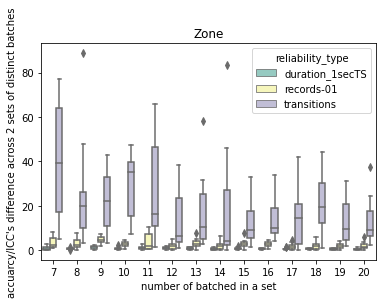

C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


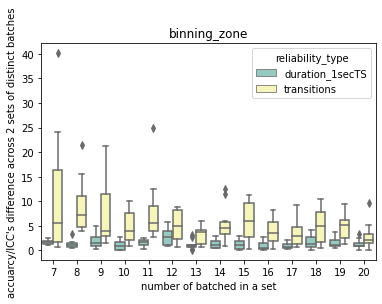

C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


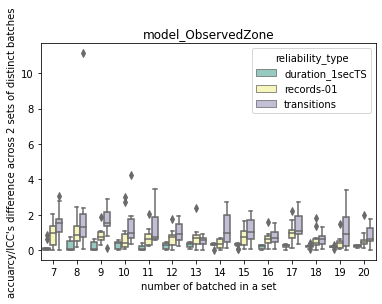

(1120, 6)


In [15]:
#visualize the results
li_df = []
li_rt = ['duration_1secTS', 'records-01', 'transitions']
for m, df_ in df_results[(df_results['nbr_batch']!=len(df_testing['BatchID'].unique()))&\
                        (~df_results['dontuse'])&(df_results['reliability_type'].isin(li_rt))].groupby(['method']):    
    #compute difference across the associated batches combination
    df_ = df_.filter(['reliability_type','accuracy_ICC','nbr_batch','runID','li_batch_selected'], axis=1)
    df_ = df_.groupby(['runID','reliability_type','nbr_batch'])['accuracy_ICC','li_batch_selected'].agg(lambda x: list(x)).reset_index()
    df_['accuracy_ICC_diff'] = df_['accuracy_ICC'].map(lambda x: abs(x[0]-x[1])*100 if len(x)==2 else np.nan)
    li_df.append(df_)
    #display(df_.head(3))
    #plot
    ax = sns.boxplot(x="nbr_batch", y="accuracy_ICC_diff", hue="reliability_type", data=df_, palette="Set3")
    plt.title(m)
    plt.xlabel('number of batched in a set')
    plt.ylabel('accuarcy/ICC\'s difference across 2 sets of distinct batches')
    plt.savefig(os.path.join(path_extracted_data_cleaning,'ReliabilityStability_'+m+'.png'), bbox_inches='tight')
    plt.show()
df_acc_diff = pd.concat(li_df)
print(df_acc_diff.shape)
df_acc_diff.to_csv(os.path.join(path_extracted_data_cleaning,'reliability_RESULTs_acc_difference_catboost.csv'), sep=';', index=False)

In [16]:
print('LOOk AT THIS AND VERIFY THE OUTPUT')
display(df_acc_diff[df_acc_diff['accuracy_ICC_diff']>30].head(10))

LOOk AT THIS AND VERIFY THE OUTPUT


,runID,reliability_type,nbr_batch,accuracy_ICC,li_batch_selected,accuracy_ICC_diff
14,05919d92-3e28-11eb-a79e-9822ef705bb4,transitions,18,"[0.6812116077102306, 0.9813931088831485]","[[ID30, ID22, ID33, ID15, ID3, ID40, ID11, ID5...",30.018150
17,0654b446-3e2a-11eb-877d-9822ef705bb4,transitions,19,"[0.8565717141429285, 0.5423728813559323]","[[ID29, ID17, ID26, ID32, ID24, ID36, ID28, ID...",31.419883
26,0af0de74-3e1b-11eb-9037-9822ef705bb4,transitions,13,"[0.6654260528893241, 0.9805959805959804]","[[ID14, ID35, ID10, ID20, ID31, ID6, ID12, ID7...",31.516993
29,0c002402-3e16-11eb-8a31-9822ef705bb4,transitions,10,"[0.5791583166332663, 0.9922424242424243]","[[ID3, ID2, ID29, ID12, ID8, ID5, ID19, ID13, ...",41.308411
35,0de36d7a-3e14-11eb-a8d1-9822ef705bb4,transitions,9,"[0.618746041798607, 0.9854077253218881]","[[ID40, ID42, ID22, ID28, ID7, ID33, ID41, ID3...",36.666168
47,13c5d906-3e13-11eb-b194-9822ef705bb4,transitions,8,"[0.9629215576672252, 0.48435814455231924]","[[ID31, ID6, ID21, ID33, ID28, ID25, ID41, ID1...",47.856341
71,22a20266-3e21-11eb-8a27-9822ef705bb4,transitions,16,"[0.9064380512735966, 0.566931132973659]","[[ID29, ID9, ID36, ID7, ID26, ID23, ID4, ID39,...",33.950692
80,2992c09e-3e27-11eb-aa20-9822ef705bb4,transitions,18,"[0.9762009872777621, 0.589852008456659]","[[ID40, ID17, ID36, ID8, ID18, ID11, ID21, ID3...",38.634898
92,302ed152-3e1c-11eb-a892-9822ef705bb4,transitions,13,"[0.975389663658736, 0.39134808853118674]","[[ID17, ID23, ID29, ID10, ID9, ID5, ID20, ID32...",58.404158
107,3c7222fa-3e25-11eb-b032-9822ef705bb4,transitions,17,"[0.5390032502708557, 0.9608016504568229]","[[ID5, ID36, ID32, ID35, ID30, ID29, ID41, ID1...",42.179840


### model classification measures

df_results = pd.read_csv(os.path.join(path_extracted_data_cleaning,'reliability_RESULTS_catboost.csv'), sep=';')
print(df_results.shape)
df_results.head(3)

#OLD
#records 0-1
#I dont think kappa makes a lot of sense in this case, as its not truly raters. 
#I dont think that any (including accuracy) for the system makes much sense as it has always a prediction of 1 for each 
#records and we counted here both transitional records as well as corectional records. Also, we dont want to overload the reader
#with to many measures, so lets stick to the best ones (at least fro our perspective)
li_measure = ['accuracy','macroavg_precision', 'macroavg_recall', 'macroavg_f1',
             '0_precision','0_recall','0_f1-score','0_support',
             '1_precision','1_recall','1_f1-score','1_support','method']
df_results[(df_results['nbr_batch']==len(df_testing['BatchID'].unique()))&\
           (df_results['reliability_type']=='records-01')&(~df_results['dontuse'])][li_measure]

In [17]:
#records 0-1 (all and per zone)
#I dont think kappa makes a lot of sense in this case, as its not truly raters. 
#I dont think that other values than accurarcy for the system makes much sense as it has always a prediciton of 1 for each 
#records and we counted here both transitional records as well as corectional records. ALso, we odnt want to overload the reader
#with to many measures, so lets stick to the best ones (at least fro our perspective)
li_measure = ['reliability_type','method','accuracy','macroavg_precision', 'macroavg_recall', 'macroavg_f1',
             '0_precision','0_recall','0_f1-score','0_support',
             '1_precision','1_recall','1_f1-score','1_support']
df_results[(df_results['nbr_batch']==len(df_testing['BatchID'].unique()))&\
           (df_results['reliability_type'].isin(['records-01','records-01_1Zone','records-01_2Zone','records-01_3Zone',
                                             'records-01_4Zone','records-01_5Zone']))&(~df_results['dontuse'])][li_measure]

,reliability_type,method,accuracy,macroavg_precision,macroavg_recall,macroavg_f1,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support
5040,records-01,model_ObservedZone,0.989571,0.939421,0.949336,0.944317,0.883721,0.904762,0.894118,42.0,0.995122,0.99391,0.994516,821.0
5041,records-01,Zone,0.951333,0.475666,0.500000,0.487530,0.000000,0.000000,0.000000,42.0,0.951333,1.00000,0.975059,821.0


# Accuracy of each cleaning methods on entire testing datasets

For duration cohen kappas + classification_report was used, for trnasition ICC

#old
li_rel_type = ['duration_1secTS', 'transitions','transitions_1Zone', 'transitions_2Zone', 'transitions_3Zone',
               'transitions_4Zone', 'transitions_5Zone']
df_plt = df_results[(df_results['nbr_batch']==len(df_testing['BatchID'].unique()))&\
                    (df_results['reliability_type'].isin(li_rel_type))&(~df_results['dontuse'])]
print(df_plt.shape)
#df_plt[['runID','method','accuracy_ICC']]
plt.figure(figsize=(8,6))
ax = sns.barplot(x="reliability_type", y="accuracy_ICC", hue="method", data=df_plt, palette="Set3")
plt.xticks(fontsize=10,rotation=70)
plt.ylim(0.2,1)
plt.xlabel('type of reliability')
plt.ylabel('accuraccy - ICC scores')
plt.savefig(os.path.join(path_extracted_data_cleaning,'ReliabilityMethodsComparison_catboost.png'), bbox_inches='tight')

(18, 57)


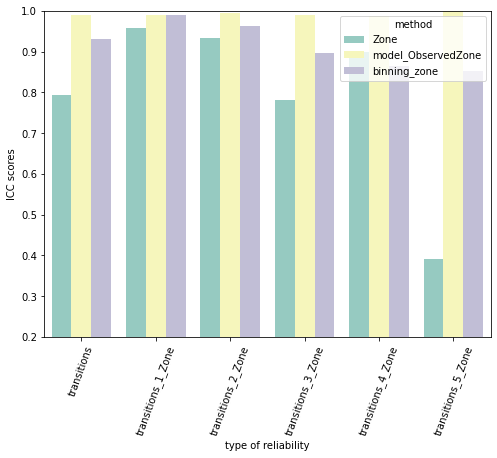

In [21]:
#transitions: continuous: ICC for verification
li_rel_type = ['transitions','transitions_1_Zone', 'transitions_2_Zone', 'transitions_3_Zone',
               'transitions_4_Zone', 'transitions_5_Zone']
df_plt = df_results[(df_results['nbr_batch']==len(df_testing['BatchID'].unique()))&\
                    (df_results['reliability_type'].isin(li_rel_type))&(~df_results['dontuse'])]
print(df_plt.shape)
#df_plt[['runID','method','accuracy_ICC']]
plt.figure(figsize=(8,6))
ax = sns.barplot(x="reliability_type", y="ICC", hue="method", data=df_plt, palette="Set3")
plt.xticks(fontsize=10,rotation=70)
plt.ylim(0.2,1)
plt.xlabel('type of reliability')
plt.ylabel('ICC scores');
#plt.savefig(os.path.join(path_extracted_data_cleaning,'ReliabilityMethodsComparison_transitions.png'), bbox_inches='tight')

In [22]:
df_results[(df_results['nbr_batch']==len(df_testing['BatchID'].unique()))&\
                    (df_results['reliability_type'].isin(li_rel_type))&(~df_results['dontuse'])]['reliability_type']

5055           transitions
5056           transitions
5057           transitions
5058    transitions_1_Zone
5059    transitions_1_Zone
5060    transitions_1_Zone
5061    transitions_2_Zone
5062    transitions_2_Zone
5063    transitions_2_Zone
5064    transitions_3_Zone
5065    transitions_3_Zone
5066    transitions_3_Zone
5067    transitions_4_Zone
5068    transitions_4_Zone
5069    transitions_4_Zone
5070    transitions_5_Zone
5071    transitions_5_Zone
5072    transitions_5_Zone
Name: reliability_type, dtype: object

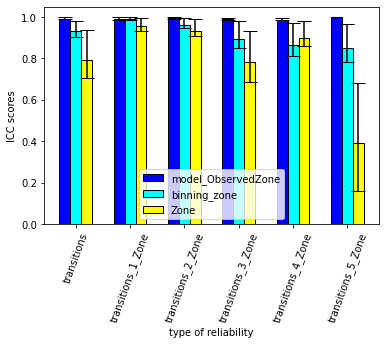

In [23]:
#transitions: continuous: ICC
li_rel_type = ['transitions','transitions_1_Zone', 'transitions_2_Zone', 'transitions_3_Zone',
               'transitions_4_Zone', 'transitions_5_Zone']
df_plt = df_results[(df_results['nbr_batch']==len(df_testing['BatchID'].unique()))&\
                    (df_results['reliability_type'].isin(li_rel_type))&(~df_results['dontuse'])]
df_plt = df_plt.sort_values(['method','reliability_type'])
# width of the bars
barWidth = 0.2
# Choose the height of the blue bars
bars1 = df_plt[df_plt['method']=='model_ObservedZone']['ICC']
bars2 = df_plt[df_plt['method']=='binning_zone']['ICC']
bars3 = df_plt[df_plt['method']=='Zone']['ICC']
yer1 = [df_plt[df_plt['method']=='model_ObservedZone']['height_lower'].tolist(), 
        df_plt[df_plt['method']=='model_ObservedZone']['height_higher'].tolist()]
yer2 = [df_plt[df_plt['method']=='binning_zone']['height_lower'].tolist(), 
        df_plt[df_plt['method']=='binning_zone']['height_higher'].tolist()]
yer3 = [df_plt[df_plt['method']=='Zone']['height_lower'].tolist(), 
        df_plt[df_plt['method']=='Zone']['height_higher'].tolist()]
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='model_ObservedZone')
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='binning_zone')
plt.bar(r3, bars3, width = barWidth, color = 'yellow', edgecolor = 'black', yerr=yer3, capsize=7, label='Zone')
plt.xticks([r + barWidth for r in range(len(bars1))], df_plt['reliability_type'].unique())
plt.xlabel('type of reliability')
plt.ylabel('ICC scores')
plt.xticks(fontsize=10,rotation=70)
plt.legend();
plt.savefig(os.path.join(path_extracted_data_cleaning,'ReliabilityMethodsComparison_transitions.png'), bbox_inches='tight')

(30, 6)


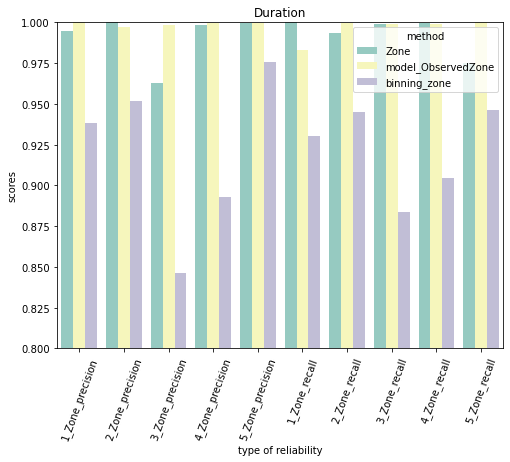

In [24]:
#duration: accuracy per zones: classification_report, kappa
#TODO: f1-score per zone:x is f1score zone1, f1_score zone 2 etc
df_plt = df_results[(df_results['nbr_batch']==len(df_testing['BatchID'].unique()))&\
                    (df_results['reliability_type']=='duration_1secTS')&(~df_results['dontuse'])]
df_plt = pd.melt(df_plt, id_vars=['runID','CPairID','method','reliability_type'], 
                 value_vars=['1_Zone_precision','2_Zone_precision','3_Zone_precision','4_Zone_precision','5_Zone_precision',
                             '1_Zone_recall','2_Zone_recall','3_Zone_recall','4_Zone_recall','5_Zone_recall'])

print(df_plt.shape)
#df_plt[['runID','method','accuracy_ICC']]
plt.figure(figsize=(8,6))
ax = sns.barplot(x="variable", y="value", hue="method", data=df_plt, palette="Set3")
plt.xticks(fontsize=10,rotation=70)
plt.ylim(0.8,1)
plt.xlabel('type of reliability')
plt.ylabel('scores');
plt.title('Duration')
plt.savefig(os.path.join(path_extracted_data_cleaning,'ReliabilityMethodsComparison_duration.png'), bbox_inches='tight')

In [ ]:
#CCC to write my own fct or use R: https://github.com/stylianos-kampakis/supervisedPCA-Python/blob/master/Untitled.py